Notebook color scheme


/home/darth/miniconda3/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


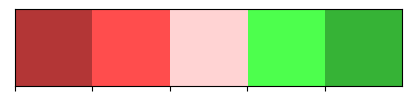

In [1]:
from typing import Any, List, Tuple, Dict, Optional, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import optuna
import os
import sys
import random
import warnings


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tqdm import tqdm_notebook


from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
import xgboost as xgb

from IPython.display import display_markdown, display_latex
from matplotlib.colors import ListedColormap

from datetime import datetime
from copy import deepcopy
from collections import defaultdict
from colorama import Fore, Style
from functools import partial

warnings.filterwarnings('ignore')

class clr:
    S = Style.BRIGHT + Fore.RED
    E = Style.RESET_ALL
    
MY_COLORS = ["#b33636", "#ff4d4d", "#ffd3d3", "#4dff4d", "#36b336"]
MY_CMAP = ListedColormap(MY_COLORS)
print(clr.S+"Notebook color scheme"+clr.E)
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()



In [2]:
df_org = pd.read_csv("./data/clean_health - clean_health.csv")
df_org.head()

,papaId,createdAt,eventType,DeviceID,MessageID,Payload,path,hops,duckType,corrupted_device,corrupted_message,charging,counter,full,volts,board_temp,packet_loss,is_lost
0,OWL_HQ,2022-03-12 0:00:10,health,IRDUCK01,UV16,Counter:58 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,58,0,-3.0,-3.0,1,0
1,OWL_HQ,2022-03-12 0:01:47,health,HEALTHDK,DE1R,Counter:61 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,61,0,-3.0,-3.0,2,1
2,OWL_HQ,2022-03-12 0:02:10,health,IRDUCK01,6T9P,Counter:59 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,59,0,-3.0,-3.0,1,0
3,OWL_HQ,2022-03-12 0:03:48,health,HEALTHDK,UVR4,Counter:62 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,62,0,-3.0,-3.0,1,0
4,OWL_HQ,2022-03-12 0:05:47,health,HEALTHDK,DVI7,Counter:63 Charging:1 Full:0 Volts:-3.00 Temp:...,NaN,1,2,0,0,1,63,0,-3.0,-3.0,1,0


In [3]:
df = df_org[['eventType', 'DeviceID', 'hops', 'duckType', 'corrupted_device', 'charging', 'counter', 'full', 'volts', 'board_temp', 'is_lost']]
df.head()

,eventType,DeviceID,hops,duckType,corrupted_device,charging,counter,full,volts,board_temp,is_lost
0,health,IRDUCK01,1,2,0,1,58,0,-3.0,-3.0,0
1,health,HEALTHDK,1,2,0,1,61,0,-3.0,-3.0,1
2,health,IRDUCK01,1,2,0,1,59,0,-3.0,-3.0,0
3,health,HEALTHDK,1,2,0,1,62,0,-3.0,-3.0,0
4,health,HEALTHDK,1,2,0,1,63,0,-3.0,-3.0,0


# Exploratory Data Analysis

In [4]:
print(clr.S+"==== Basic Data Information ====="+clr.E)
display_markdown(f"Number of records in the data : ${df.shape[0]}$", raw=True)
display_markdown(f"Number of attributes in the data: ${df.shape[1] - 1}$", raw=True)
print("\n\n")

print(clr.S+"===== Number of unique instances ======"+clr.E)

for col in df.columns:
    if col != "is_lost":
        display_markdown(f"Number of unique values is `{col}`: ${df[col].nunique()}$", raw=True)
print("\n\n")

==== Basic Data Information =====


Number of records in the data : $92451$

Number of attributes in the data: $10$




===== Number of unique instances ======


Number of unique values is `eventType`: $1$

Number of unique values is `DeviceID`: $2$

Number of unique values is `hops`: $3$

Number of unique values is `duckType`: $2$

Number of unique values is `corrupted_device`: $1$

Number of unique values is `charging`: $2$

Number of unique values is `counter`: $52487$

Number of unique values is `full`: $1$

Number of unique values is `volts`: $72$

Number of unique values is `board_temp`: $298$

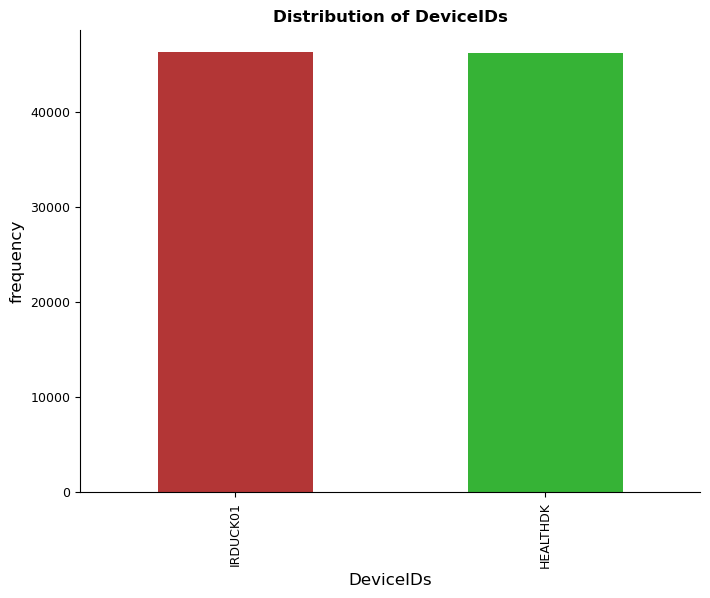

In [5]:
ax = df["DeviceID"].value_counts().plot(kind="bar", 
                                   figsize=(8, 6), 
                                   color=[MY_COLORS[0], MY_COLORS[-1]], fontsize=9)
ax.set_title("Distribution of DeviceIDs", fontsize=12, weight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("DeviceIDs", fontsize=12)
ax.set_ylabel("frequency", fontsize=12)
plt.show()

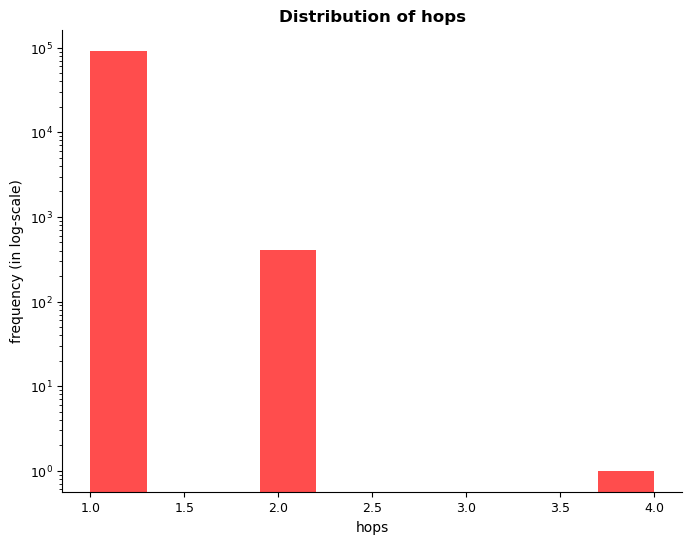

In [6]:
ax = df["hops"].plot(kind="hist", 
                     figsize=(8, 6), 
                     color=MY_COLORS[1], fontsize=9)

ax.set_yscale('log')
ax.set_title("Distribution of hops", fontsize=12, weight="bold")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("hops", fontsize=10)
ax.set_ylabel("frequency (in log-scale)", fontsize=10)

plt.show()

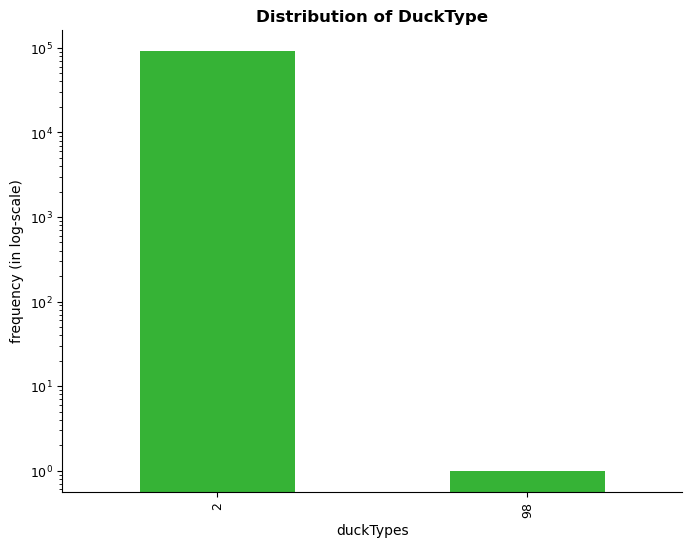

In [7]:
ax = df['duckType'].value_counts().plot(kind="bar",
                                       figsize=(8, 6), color=MY_COLORS[-1], fontsize=9)
ax.set_title("Distribution of DuckType", fontsize=12, weight="bold")
ax.set_yscale('log')

ax.set_ylabel("frequency (in log-scale)", fontsize=10)
ax.set_xlabel("duckTypes", fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

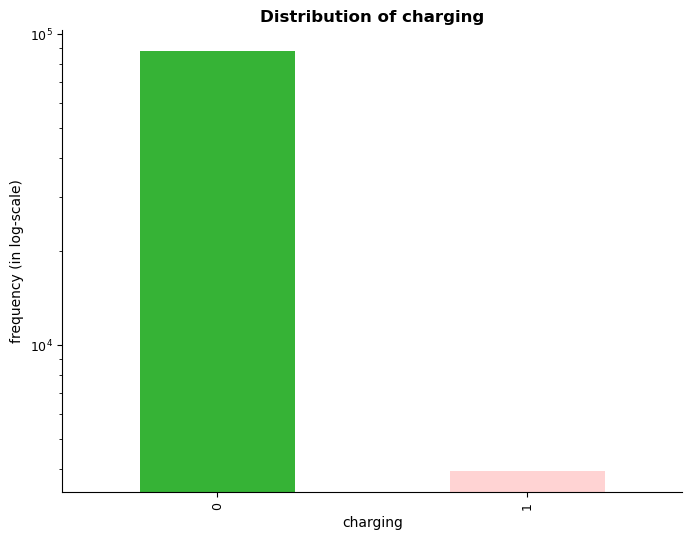

In [8]:
ax = df['charging'].value_counts().plot(kind="bar",
                                       figsize=(8, 6), color=[MY_COLORS[-1], MY_COLORS[-3]], fontsize=9)
ax.set_title("Distribution of charging", fontsize=12, weight="bold")
ax.set_yscale('log')

ax.set_ylabel("frequency (in log-scale)", fontsize=10)
ax.set_xlabel("charging", fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

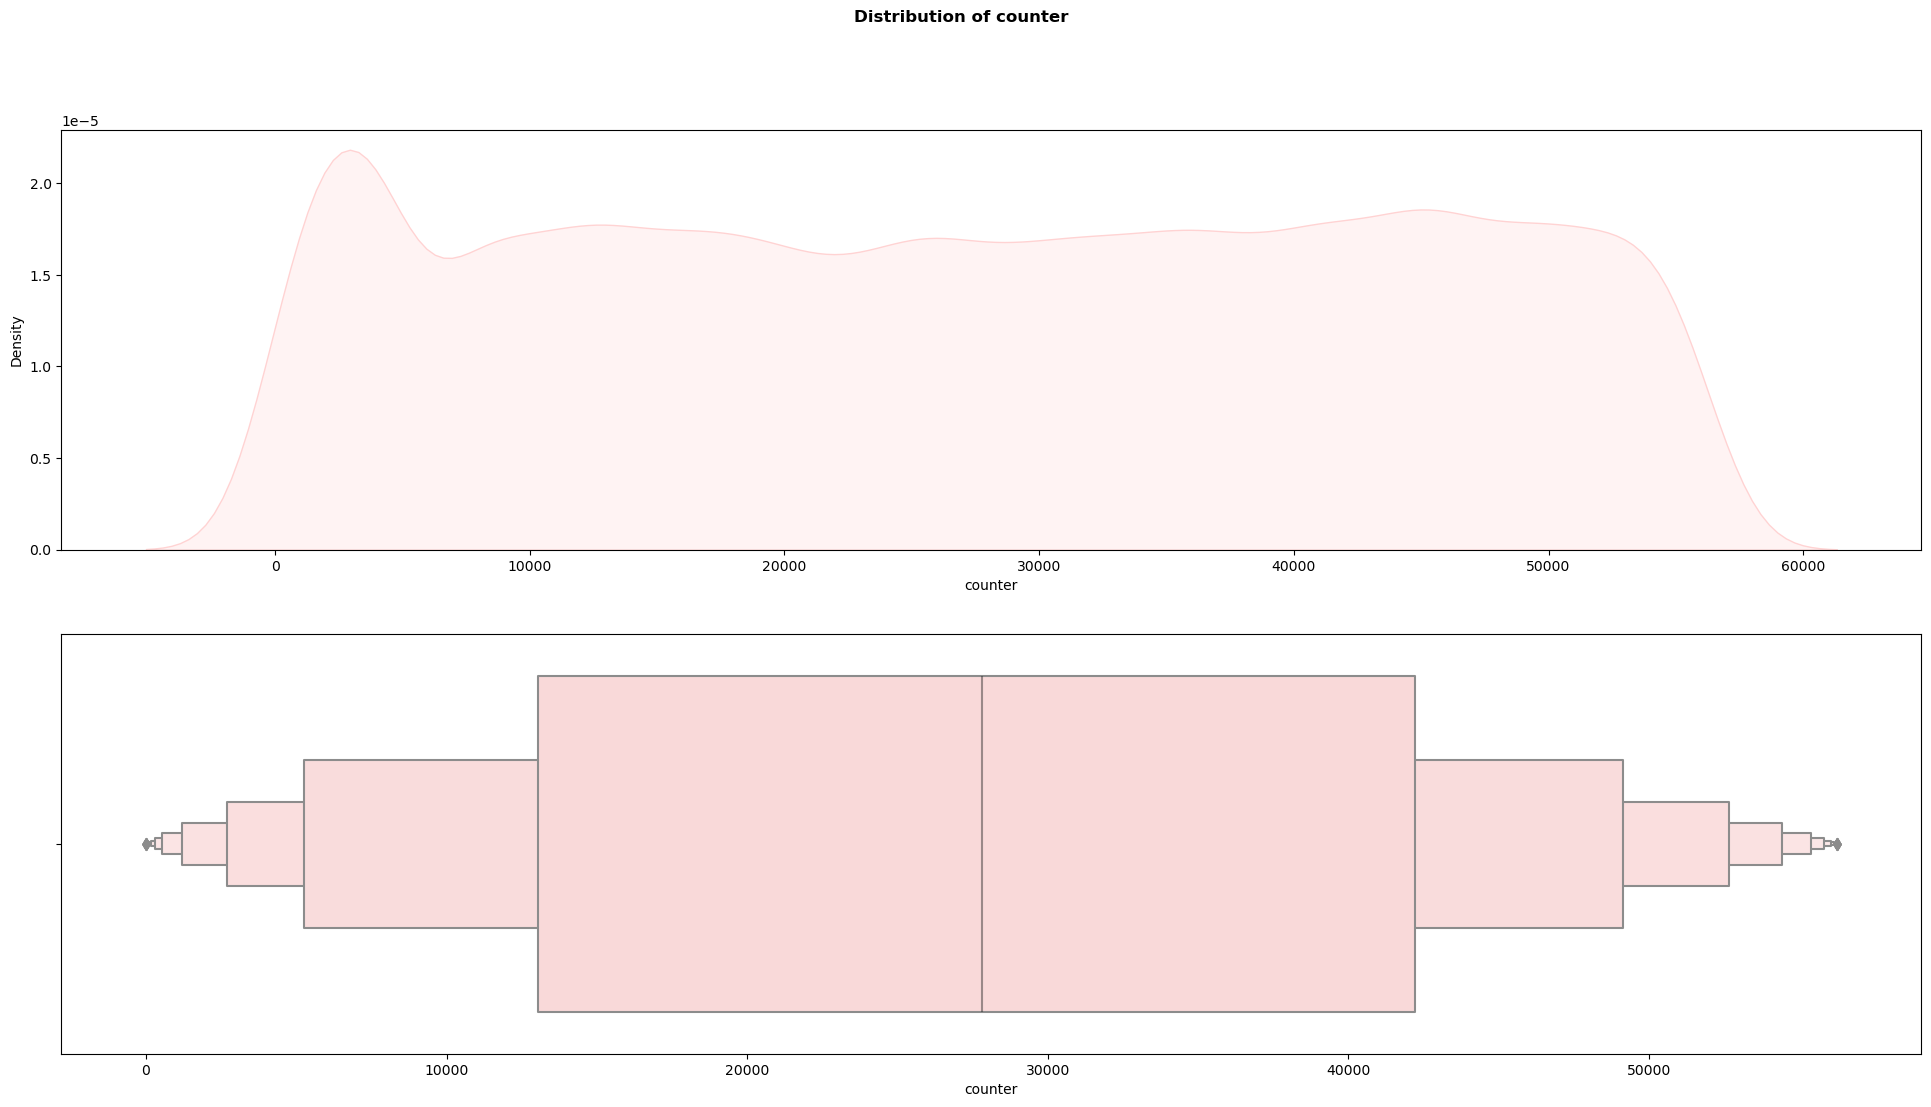

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of counter", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="counter", color=MY_COLORS[-3], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="counter", color=MY_COLORS[-3], ax=axs[1])
plt.show()


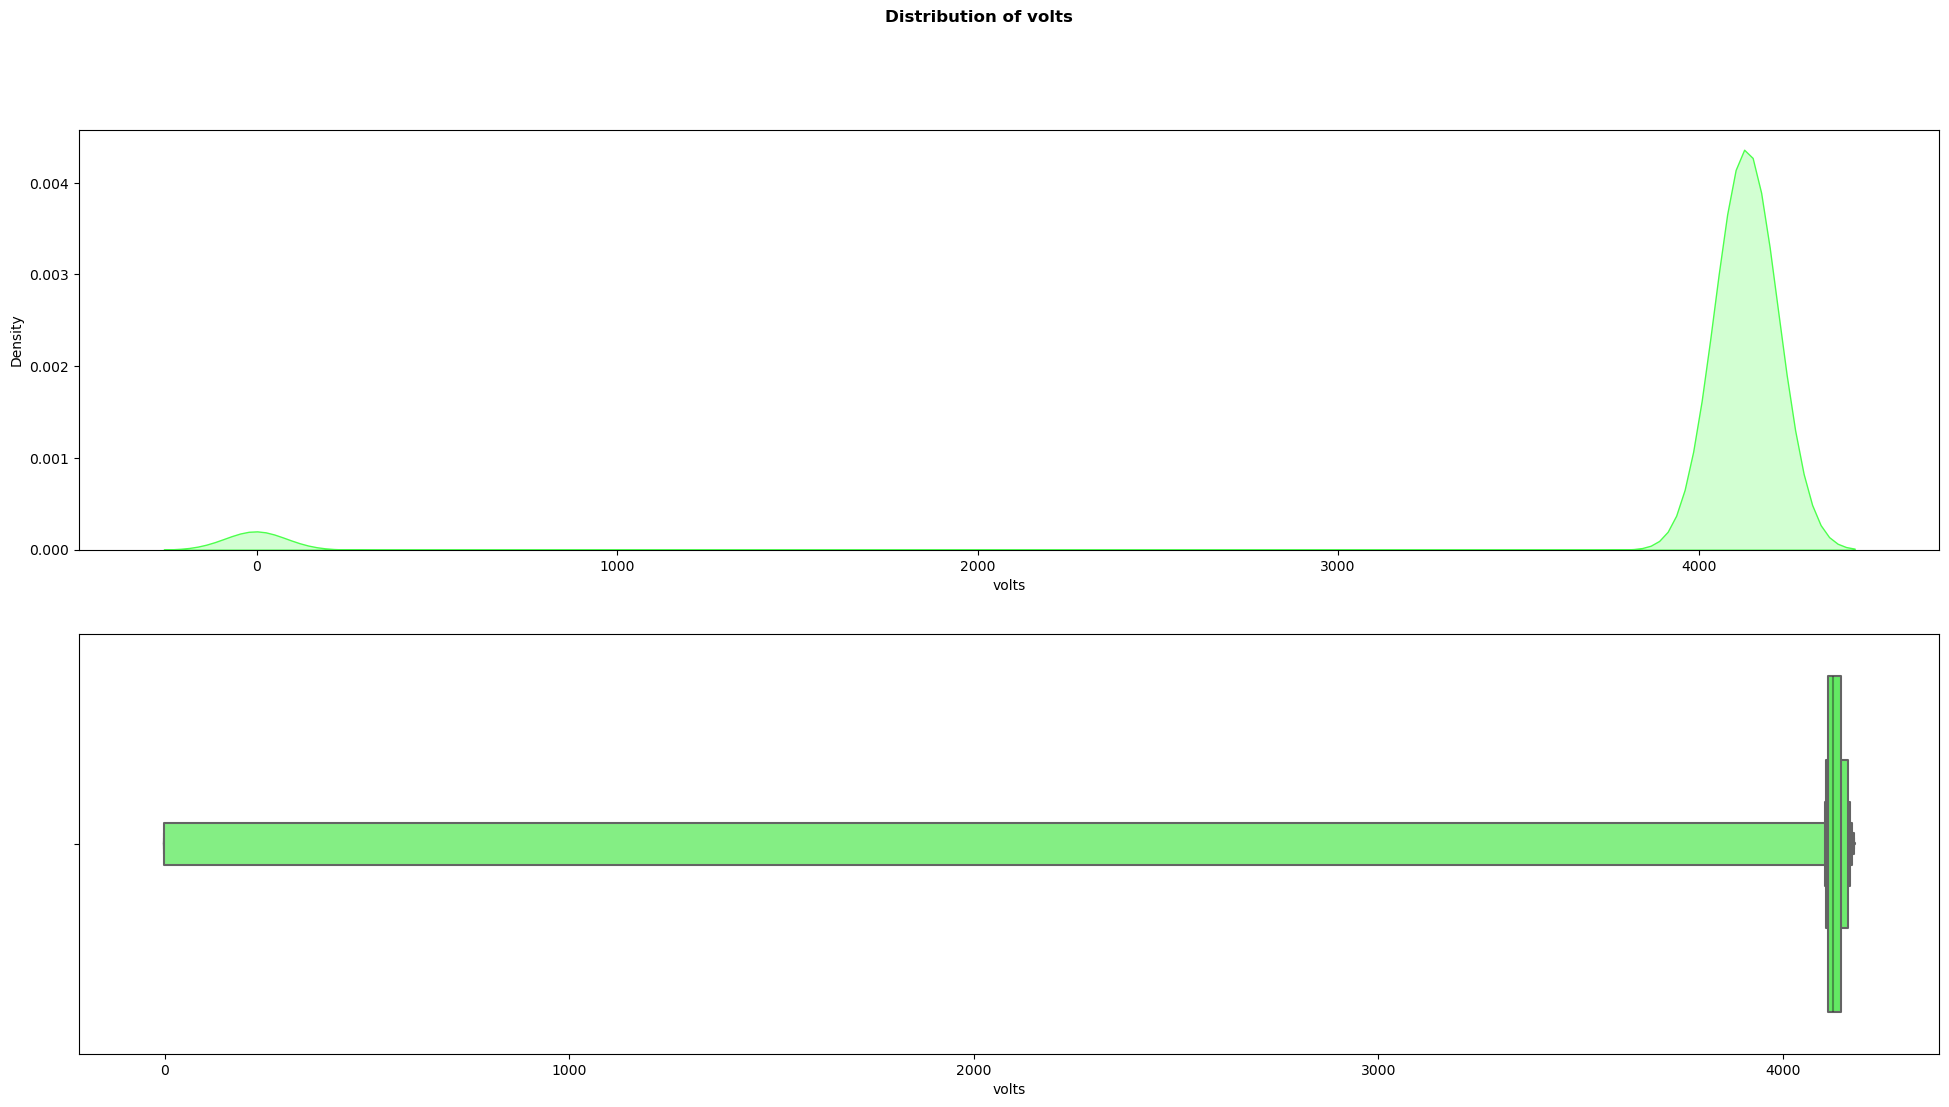

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of volts", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="volts", color=MY_COLORS[-2], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="volts", color=MY_COLORS[-2], ax=axs[1])
plt.show()


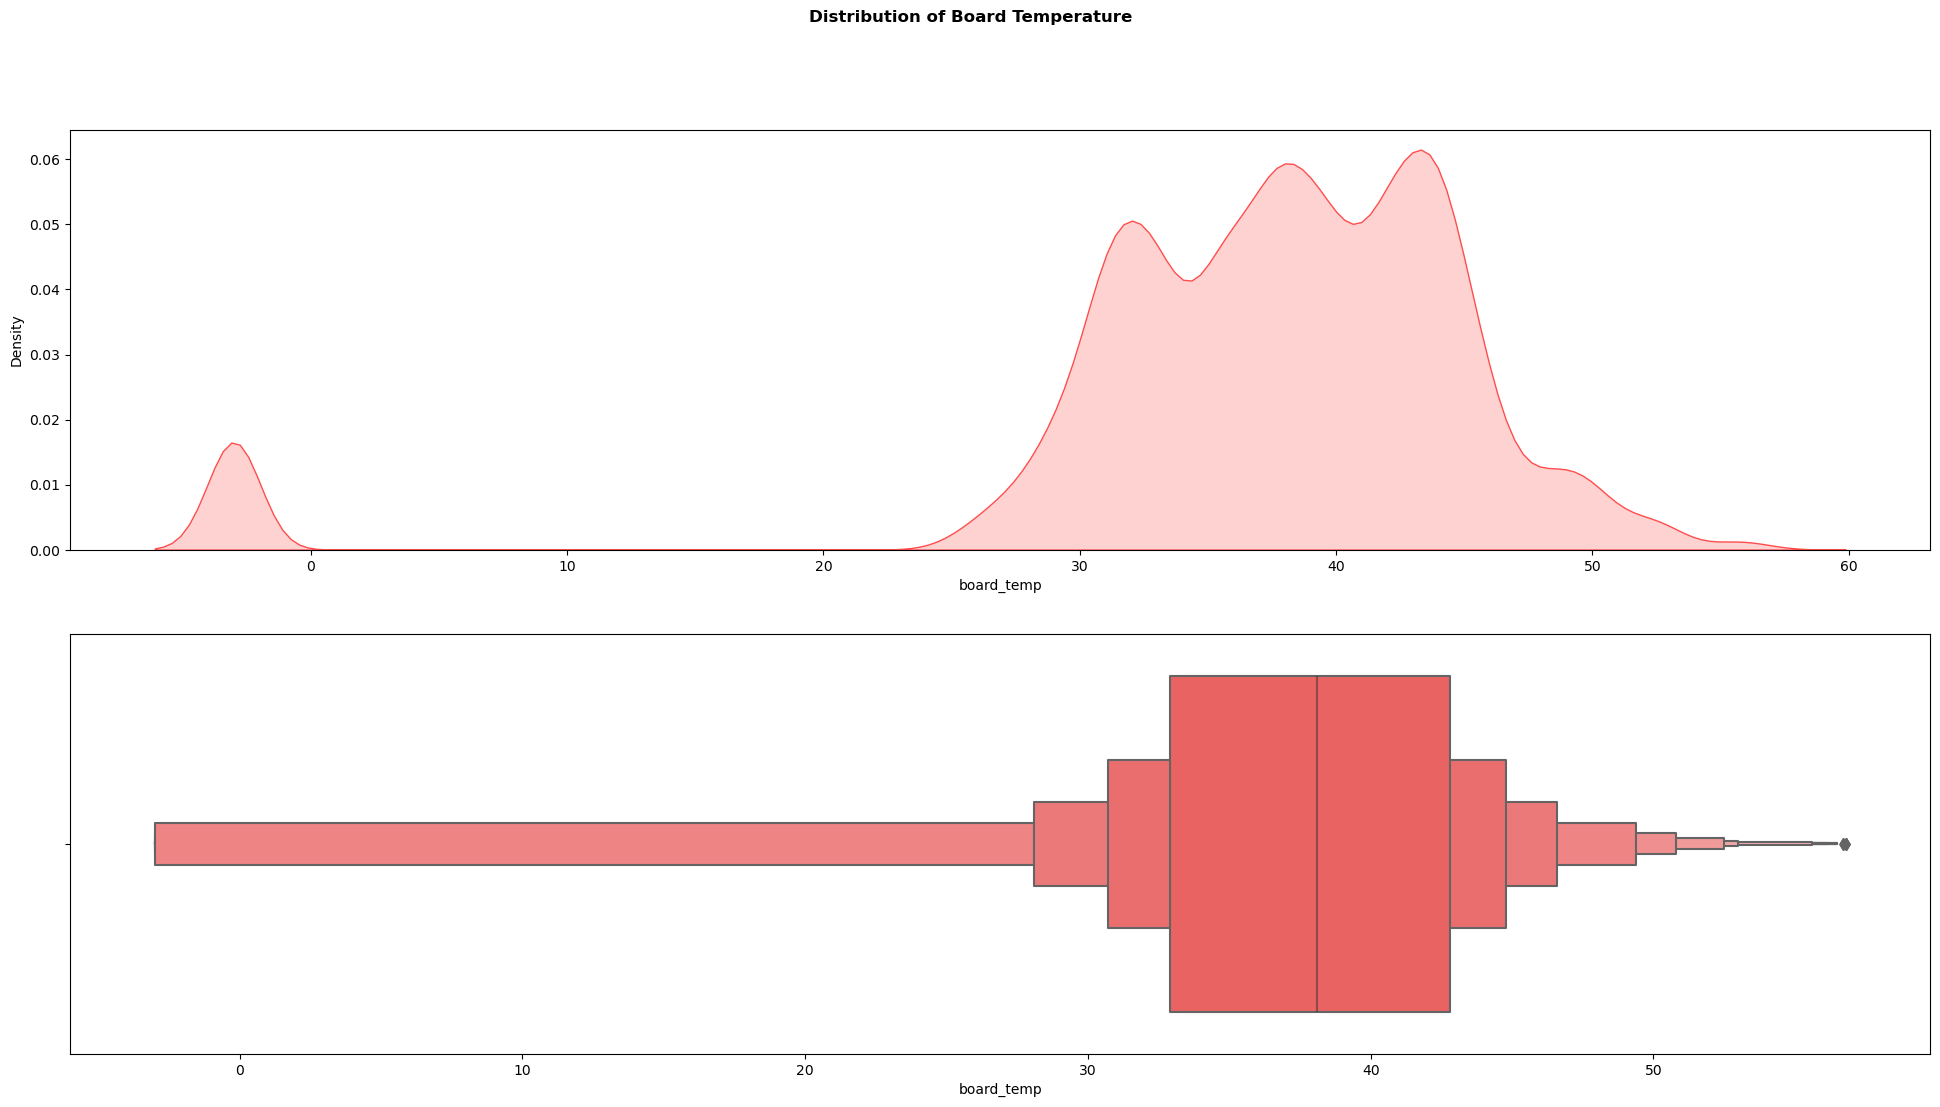

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs = axs.flatten()

fig.suptitle("Distribution of Board Temperature", fontsize=12, weight="bold")
sns.kdeplot(data=df, x="board_temp", color=MY_COLORS[1], fill=True, ax=axs[0])
sns.boxenplot(data=df, x="board_temp", color=MY_COLORS[1], ax=axs[1])
plt.show()


# Distribution of Target Variable

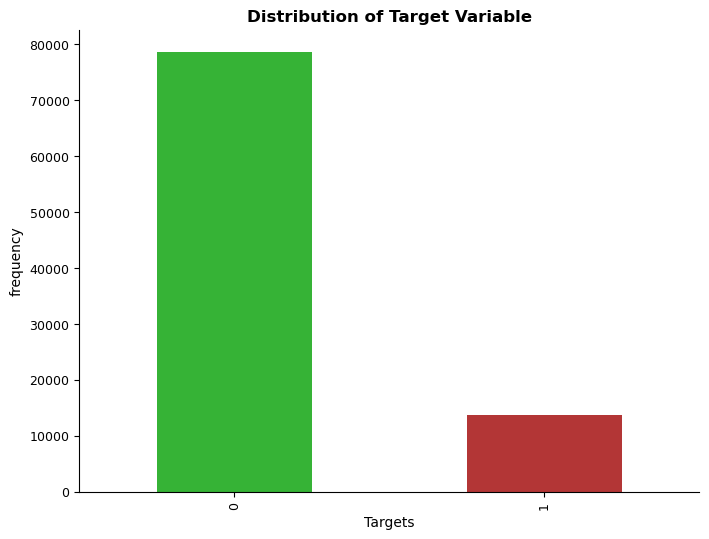

In [12]:
ax = df['is_lost'].value_counts().plot(kind="bar", figsize=(8, 6), 
                                       color = [MY_COLORS[-1], MY_COLORS[0]], fontsize=9)

ax.set_title("Distribution of Target Variable", fontsize=12, weight="bold")
ax.set_xlabel("Targets")
ax.set_ylabel("frequency")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

# Notable Observations from the EDA

* For attributes such as `eventType` and `charging` the number of unique values is $1$, which therefore suggests that these attributes should be dropped while modelling as it will provide no additional input to the model.

* There is only $1$ instance when the number of `hops` is $>=4$. This suggests, that the following data point can be removed as a single point will provide no additional benefit to the data modeling.
* There is only $1$ instance of `duckType` $=98$, and removing that will lead to the attribute having a single unique value which will not be of great importance. Hence, it's better that it's ignored while modeling.
* Similarly, for `charging` the same procedure of `duckType` can be adopted.

* From the plots for the `volts` and `board_temp` it is seen that there are quite a few observations where a value of $<0$ is present. This value indicates that the sensor was unable to read the values during that time.

* From the distribution of the target variable it is obvious that we are dealing with imbalanced classes.

# Data Cleaning

In [13]:
df = df[df['hops'] != 4]
df = df[['DeviceID', 'hops', 'board_temp', 'volts', 'counter', 'is_lost']]

# Data Splitting

In [14]:
df_train, df_test = train_test_split(df, test_size=.25, random_state=42, stratify=df['is_lost'])

print(clr.S+"====Training Data Information===="+clr.E)
display_markdown(f"Number of records : ${df_train.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_train.shape[1] - 1}$", raw=True)
print("\n\n")


print(clr.S+"====Test Data Information===="+clr.E)
display_markdown(f"Number of records : ${df_test.shape[0]}$", raw=True)
display_markdown(f"Number of attributes : ${df_test.shape[1] - 1}$", raw=True)
print("\n\n")


====Training Data Information====


Number of records : $69337$

Number of attributes : $5$




====Test Data Information====


Number of records : $23113$

Number of attributes : $5$

# Class Weight Calculation

In [15]:
n_neg = df_train[df_train['is_lost'] == 0].shape[0]
n_pos = df_train[df_train['is_lost'] == 1].shape[0]

display_markdown(f"Number of `pos` classes : ${n_pos}$", raw=True)
display_markdown(f"Number of `neg` classes : ${n_neg}$", raw=True)

class_wts = {0:1/(n_neg/(n_neg+n_pos)), 1:1/(n_pos/(n_neg+n_pos))}

Number of `pos` classes : $10324$

Number of `neg` classes : $59013$

# Data Modelling

## - Define Model Scoring function

In [16]:
def score_fn(y_true:np.ndarray, y_pred:np.ndarray) -> float:
    """
    This function calculates the model score and returns it.
    
    :param y_true: the true value of the data.
    :param y_pred: the predicted value of the data.
    
    :returns: the model score on the data.
    """
    
    score = f1_score(y_true, y_pred)
    return score

## - Defining Hyperparameter Optimization Function

In [17]:
def objective(trial:optuna.Trial, data:pd.DataFrame, model_name:str, n_splits:Optional[int]=5, class_weights:Optional[Dict]=None) -> float:
    """
    This function is used as a optimization function for optuna
    
    :param trial: an optuna object to keep track of trials.
    :param data: the data on which to optimize the hyperparameters.
    :param model_name: the name of the model to optimize
    :param n_splits: the number of splits for cross-validation.
    :param class_weights: the class weights for the classes.
    
    :returns: the score of the model on the data.
    """
    
    model_names = ["LogReg", "XGB", "NB", "IF"]
    if model_name not in model_names:
        raise Exception(f"Expected model names to be either {'/'.join(model_name)}; found {model_name}!")
    
    
    if model_name == "LogReg":
        model_params = {
            "C" : trial.suggest_categorical("C", [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1., 10, 100, 500, 1000]),
            "class_weight" : trial.suggest_categorical("class_weight", [None, class_weights])            
        }
    elif model_name == "XGB":
        model_params = {
            "n_estimators" : trial.suggest_int("n_estimators", 100, 5000, step=100),
            "eta" : trial.suggest_float("eta", 1e-4, 1., log=True),
            "max_depth" : trial.suggest_int("max_depth", 6, 32, step=2),
            "lambda" : trial.suggest_float("lambda", 1e-2, 10),
            "alpha" : trial.suggest_float("alpha", 1e-2, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 1e-5, 1),
            "scale_pos_weight" : trial.suggest_categorical("scale_pos_weight", [1, n_neg / n_pos])
        }
    elif model_name == "NB":
        model_params = {
            "alpha" : trial.suggest_float("alpha", 1e-2, 1)            
        }
    else:
        model_params = {
            "n_estimators" : trial.suggest_int("n_estimators", 100, 10000, step=100),
            "contamination": trial.suggest_float("contamination", 0, 0.5)            
        }
    
    
    
    models = {
        "LogReg" : LogisticRegression,
        "XGB" : xgb.XGBClassifier,
        "NB" : ComplementNB,
        "IF" : IsolationForest
    }
    
    
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = list()
    
    for (train_idx, val_idx) in kfold.split(data.iloc[:, :-1], data.iloc[:, -1]):
        train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
        
        if model_name == "XGB":
            model = models[model_name](objective="binary:logistic",
                                       sampling_method="gradient_based", 
                                       tree_method="gpu_hist", 
                                       grow_policy="lossguide", 
                                       predictor="gpu_predictor", verbosity=3, random_state=42, n_jobs=-1, **model_params)
        elif model_name == "NB":
            model = models[model_name](**model_params)
        else:
            model = models[model_name](n_jobs=-1, **model_params, random_state=42)
            
        pipeline = Pipeline([
            ("preprocess", ColumnTransformer(
                transformers = [
                    ("numeric_feats", MinMaxScaler(), ["hops", "counter", "board_temp", "volts"]), 
                ], remainder="passthrough"
            ),),
            ("model", model)
        ])
            
        pipeline.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1])
        
        val_preds = pipeline.predict(val_data.iloc[:, :-1])
        score = score_fn(val_data.iloc[:, -1], val_preds)
        scores.append(score)
        
    return np.mean(scores)

In [18]:
def early_stop_check(study:optuna.study.Study, trial:optuna.trial.Trial, rounds:int=5) -> None:
    """
    This function acts as a early stopping criteria for optuna.
    
    :param study: the optuna study.
    :param trial: the optuna trial.
    :param rounds: number of steps to follow before early-stopping.
    
    """
    curnt_trl_num = trial.number
    bst_trl_num = study.best_trial.number
    diff = curnt_trl_num - bst_trl_num
    
    if diff >= rounds:
        print(clr.S+"Early Stopping detected !!"+clr.E)
        study.stop()

In [19]:
def run_optuna_trials(data:pd.DataFrame, model_name:str, n_splits:Optional[int]=5, 
                      class_weights:Optional[Dict]=None, n_trials:Optional[int]=50, early_stop_rounds:Optional[int]=3) -> Dict:
    """
    Function to run the optuna trials and produce the hyperparameters for the data.
    
    :param data: the training data.
    :param model_name: the name of the model
    :param n_splits: number of Cross-Validation splits
    :param class_weights: the class_weights.
    :param n_trials: the number of optuna trials.
    
    :returns: the best hyperparameters.
    """
    
    sampler = optuna.samplers.TPESampler(seed=1234)
    study = optuna.create_study(
        study_name = f"{model_name}_study",
        sampler = sampler,
        direction = "maximize",
        load_if_exists = True,
        storage="sqlite:///study_duckprotocol.db"
    )
    
    func = lambda trial: objective(trial, data, model_name, n_splits=n_splits, class_weights=class_weights)
    
    study.optimize(func, n_trials=n_trials, callbacks=[partial(early_stop_check, rounds=early_stop_rounds)])
    
    best_hyp = dict()
    
    for k, v in study.best_trial.params.items():
            best_hyp[k] = v
    
    return best_hyp

## - Label Encoding Categorical data

In [20]:
device_label_encoder = LabelEncoder()
device_label_encoder.fit(df['DeviceID'].values)

df_train['DeviceID'] = device_label_encoder.transform(df_train['DeviceID'].values)
df_test['DeviceID'] = device_label_encoder.transform(df_test['DeviceID'].values)

## - Logistic Regression (Baseline)

In [21]:
log_reg_best_hyp = run_optuna_trials(df_train, "LogReg", class_weights=class_wts, early_stop_rounds=5)

[I 2023-01-27 01:56:05,843] Using an existing study with name 'LogReg_study' instead of creating a new one.
[I 2023-01-27 01:56:07,775] Trial 11 finished with value: 0.25086927182076596 and parameters: {'C': 1000, 'class_weight': {0: 1.1749445037534103, 1: 6.7160984114684235}}. Best is trial 3 with value: 0.25992043134202425.


Early Stopping detected !!


## - XGBoost

In [22]:
xgb_best_hyp = run_optuna_trials(df_train, "XGB", class_weights=class_wts, early_stop_rounds=5)

[I 2023-01-27 01:56:07,808] Using an existing study with name 'XGB_study' instead of creating a new one.


[01:56:08] ======== Monitor (0): HostSketchContainer ========
[01:56:08] AllReduce: 0.000734s, 1 calls @ 734us

[01:56:08] MakeCuts: 0.000774s, 1 calls @ 774us

[01:56:08] DEBUG: ../src/tree/updater_gpu_hist.cu:736: [GPU Hist]: Configure
[01:56:08] ======== Monitor (0):  ========
[01:56:08] InitCompressedData: 1.4e-05s, 1 calls @ 14us

[01:56:46] ======== Monitor (0): Learner ========
[01:56:46] Configure: 0.206417s, 1 calls @ 206417us

[01:56:46] EvalOneIter: 0.008184s, 4000 calls @ 8184us

[01:56:46] GetGradient: 0.065486s, 4000 calls @ 65486us

[01:56:46] PredictRaw: 0.002192s, 4000 calls @ 2192us

[01:56:46] UpdateOneIter: 38.4561s, 4000 calls @ 38456081us

[01:56:46] ======== Monitor (0): GBTree ========
[01:56:46] BoostNewTrees: 38.1601s, 4000 calls @ 38160063us

[01:56:46] CommitModel: 0.000455s, 4000 calls @ 455us

[01:56:46] ======== Device 0 Memory Allocations:  ========
[01:56:46] Peak memory usage: 34MiB
[01:56:46] Number of allocations: 2795875
[01:56:46] ======== Monitor 

[I 2023-01-27 01:59:41,110] Trial 20 finished with value: 0.03253157263295756 and parameters: {'n_estimators': 4000, 'eta': 0.00572214920911668, 'max_depth': 32, 'lambda': 9.840148310092836, 'alpha': 8.974184860730581, 'colsample_bytree': 0.8373775085375122, 'scale_pos_weight': 1}. Best is trial 14 with value: 0.3155250229198117.


[01:59:41] ======== Monitor (0): Learner ========
[01:59:41] Configure: 0.000791s, 1 calls @ 791us

[01:59:41] EvalOneIter: 0.009928s, 4000 calls @ 9928us

[01:59:41] GetGradient: 0.09117s, 4000 calls @ 91170us

[01:59:41] PredictRaw: 0.001933s, 4000 calls @ 1933us

[01:59:41] UpdateOneIter: 43.0141s, 4000 calls @ 43014126us

[01:59:41] ======== Monitor (0): GBTree ========
[01:59:41] BoostNewTrees: 42.8938s, 4000 calls @ 42893765us

[01:59:41] CommitModel: 0.000577s, 4000 calls @ 577us

[01:59:41] ======== Device 0 Memory Allocations:  ========
[01:59:41] Peak memory usage: 39MiB
[01:59:41] Number of allocations: 14428584
[01:59:41] ======== Monitor (0): updater_gpu_hist ========
[01:59:41] InitData: 0.000892s, 4000 calls @ 892us

[01:59:41] InitDataOnce: 0.000538s, 1 calls @ 538us

[01:59:41] Update: 42.8716s, 4000 calls @ 42871599us

[01:59:41] UpdatePredictionCache: 0.009794s, 4000 calls @ 9794us

[01:59:41] ======== Monitor (0): gradient_based_sampler ========
[01:59:41] Sample: 0

## - Complement Naive Bayes

In [23]:
cnb_best_hyp = run_optuna_trials(df_train, "NB", class_weights=class_wts, early_stop_rounds=5)

[I 2023-01-27 01:59:41,144] Using an existing study with name 'NB_study' instead of creating a new one.
[I 2023-01-27 01:59:41,294] Trial 1 finished with value: 0.23339239679899806 and parameters: {'alpha': 0.19960425587510336}. Best is trial 1 with value: 0.23339239679899806.
[I 2023-01-27 01:59:41,445] Trial 2 finished with value: 0.2324644723826863 and parameters: {'alpha': 0.6258876833294336}. Best is trial 1 with value: 0.23339239679899806.
[I 2023-01-27 01:59:41,570] Trial 3 finished with value: 0.23707370810809927 and parameters: {'alpha': 0.44335046161704333}. Best is trial 3 with value: 0.23707370810809927.
[I 2023-01-27 01:59:41,681] Trial 4 finished with value: 0.23339537474362126 and parameters: {'alpha': 0.7875049978766315}. Best is trial 3 with value: 0.23707370810809927.
[I 2023-01-27 01:59:41,813] Trial 5 finished with value: 0.23355237303399243 and parameters: {'alpha': 0.7821760500376155}. Best is trial 3 with value: 0.23707370810809927.
[I 2023-01-27 01:59:41,940] Tr

Early Stopping detected !!


In [42]:
def confusion_display(y_true:np.ndarray, y_pred:np.ndarray) -> None:
    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    
    grp = ["True Neg", "False Pos", "False Neg", "True Pos"]
    annot = [f"{x1}\n{np.round(x2, 2)}" for x1, x2 in zip(grp, conf_mat.flatten())]
    annot = np.array(annot).reshape(2, 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("Confusion Matrix", fontsize=16, weight="bold")
    sns.heatmap(conf_mat, annot=annot, fmt="", ax=ax,
                cmap=MY_CMAP, cbar=True, linewidths=2.0)
    ax.set_xticklabels(["No LOSS", "LOSS"])
    ax.set_yticklabels(["No LOSS", "LOSS"])
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Acutal")
    plt.show()
    

In [32]:
def model_results(train:pd.DataFrame, test:pd.DataFrame, model:Any) -> Tuple:
    """
    This function fits a model and calculates the predictions of the test data. 
    Returns a classification report along with test predictions.
    
    :param train: the training dataset.
    :param test: the test dataset.
    :param model: the model to be trained and evaluated.
    
    :returns: the test predictions and classification report.
    """
    
    pipeline = Pipeline([
        ("preprocess", ColumnTransformer(
            transformers = [
                ("numeric_feats", MinMaxScaler(), ["hops", "counter", "board_temp", "volts"]), 
            ], remainder="passthrough"
        ),),
        ("model", model)
    ])
    
    X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
    pipeline.fit(X_train, y_train)
    
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
    
    y_pred = pipeline.predict(X_test)
    class_rep = classification_report(y_test, y_pred)
    
    return y_pred, class_rep

## - Re-training Models

### 1. Logistic Regression

In [38]:
log_reg = LogisticRegression(n_jobs=-1, random_state=42, C=log_reg_best_hyp["C"], class_weight=class_wts)
print(log_reg, "\n\n")
log_reg_preds, log_reg_class_rep = model_results(df_train, df_test, log_reg)

print(clr.S+"====== Logistic Regression Classification Report ======"+clr.E)
print(log_reg_class_rep)

LogisticRegression(C=0.0001,
                   class_weight={0: 1.1749445037534103, 1: 6.7160984114684235},
                   n_jobs=-1, random_state=42) 


====== Logistic Regression Classification Report ======
              precision    recall  f1-score   support

           0       0.86      0.48      0.62     19671
           1       0.16      0.55      0.25      3442

    accuracy                           0.49     23113
   macro avg       0.51      0.52      0.43     23113
weighted avg       0.76      0.49      0.56     23113



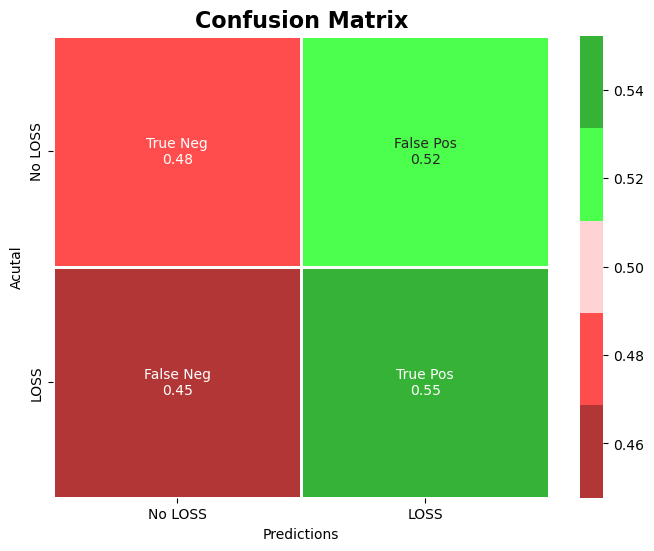

In [43]:
confusion_display(df_test.iloc[:, -1].values, log_reg_preds)

### 2. XGBoost Model

In [44]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                                       sampling_method="gradient_based", 
                                       tree_method="gpu_hist", 
                                       grow_policy="lossguide", 
                                       predictor="gpu_predictor", verbosity=3, random_state=42, n_jobs=-1, **xgb_best_hyp)

print(xgb_clf, "\n\n")
xgb_pred, xgb_class_rep = model_results(df_train, df_test, xgb_clf)

print(clr.S+"====== XGBoost Classification Report ======"+clr.E)
print(xgb_class_rep)

XGBClassifier(alpha=9.952617990189744, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9406223501960553, early_stopping_rounds=None,
              enable_categorical=False, eta=0.0007653558965178788,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=9.288778838640328,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=28,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=3300, n_jobs=-1, ...) 


[02:51:34] ======== Monitor (0): HostSketchContainer ========
[02:51:34] AllReduce: 0.000375s, 1 calls @ 375us

[02:51:34] MakeCuts: 0.000415s, 1 calls @ 415us

[02:51:34] DEBUG: ../src/tree/updater_gpu_hist.

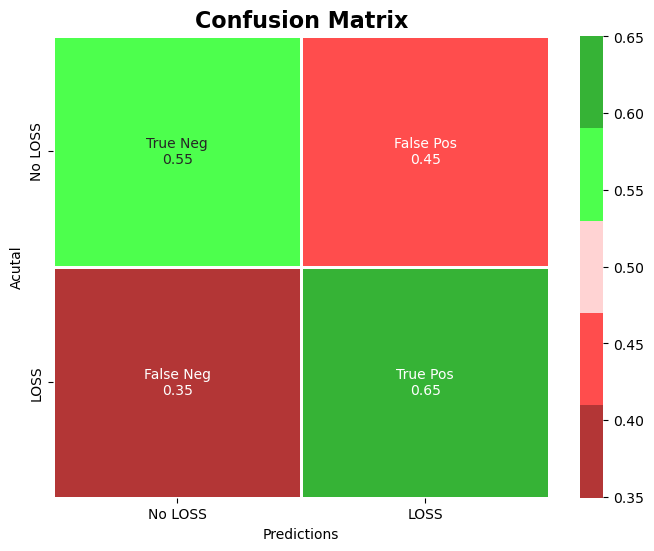

In [45]:
confusion_display(df_test.iloc[:, -1].values, xgb_pred)

### 3. Complement Naive Bayes

In [46]:
cnb = ComplementNB(**cnb_best_hyp)
print(cnb, "\n\n")

cnb_preds, cnb_class_rep = model_results(df_train, df_test, cnb)
print(clr.S+"====== Complement Naive Bayes Classification Report ======"+clr.E)
print(cnb_class_rep)

ComplementNB(alpha=0.44335046161704333) 


====== Complement Naive Bayes Classification Report ======
              precision    recall  f1-score   support

           0       0.85      0.48      0.61     19671
           1       0.15      0.52      0.23      3442

    accuracy                           0.48     23113
   macro avg       0.50      0.50      0.42     23113
weighted avg       0.74      0.48      0.55     23113



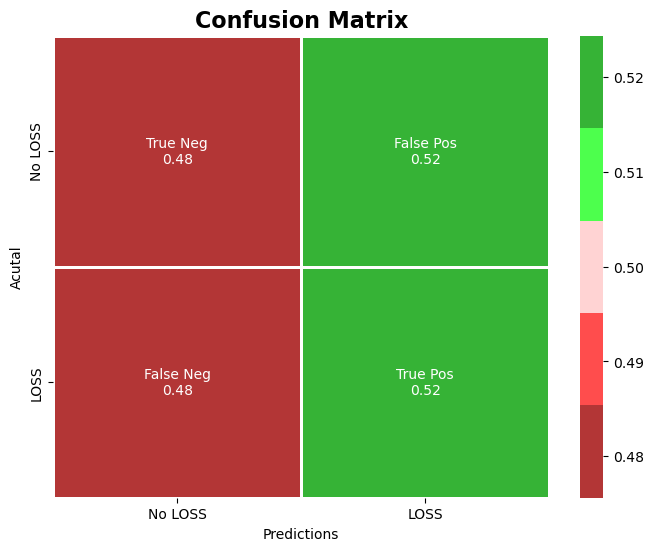

In [47]:
confusion_display(df_test.iloc[:, -1].values, cnb_preds)